In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=250,fontsize=10)

In [4]:
adata = sc.read_h5ad("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_C2-3.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 10342 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obs['arterial_ec'] = (adata.X[:,adata.var_names=='GJA5'] > 1) & (adata.X[:,adata.var_names=='VWF'] > 1)

In [7]:
adata_aec = adata[adata.obs['arterial_ec'] == True]

In [8]:
adata_aec

View of AnnData object with n_obs × n_vars = 27 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
data = adata_aec.obs[['X_coor','Y_coor']]
linkage_data = linkage(data, method='average', metric='euclidean')

In [10]:
temp = dendrogram(linkage_data,no_plot=True)

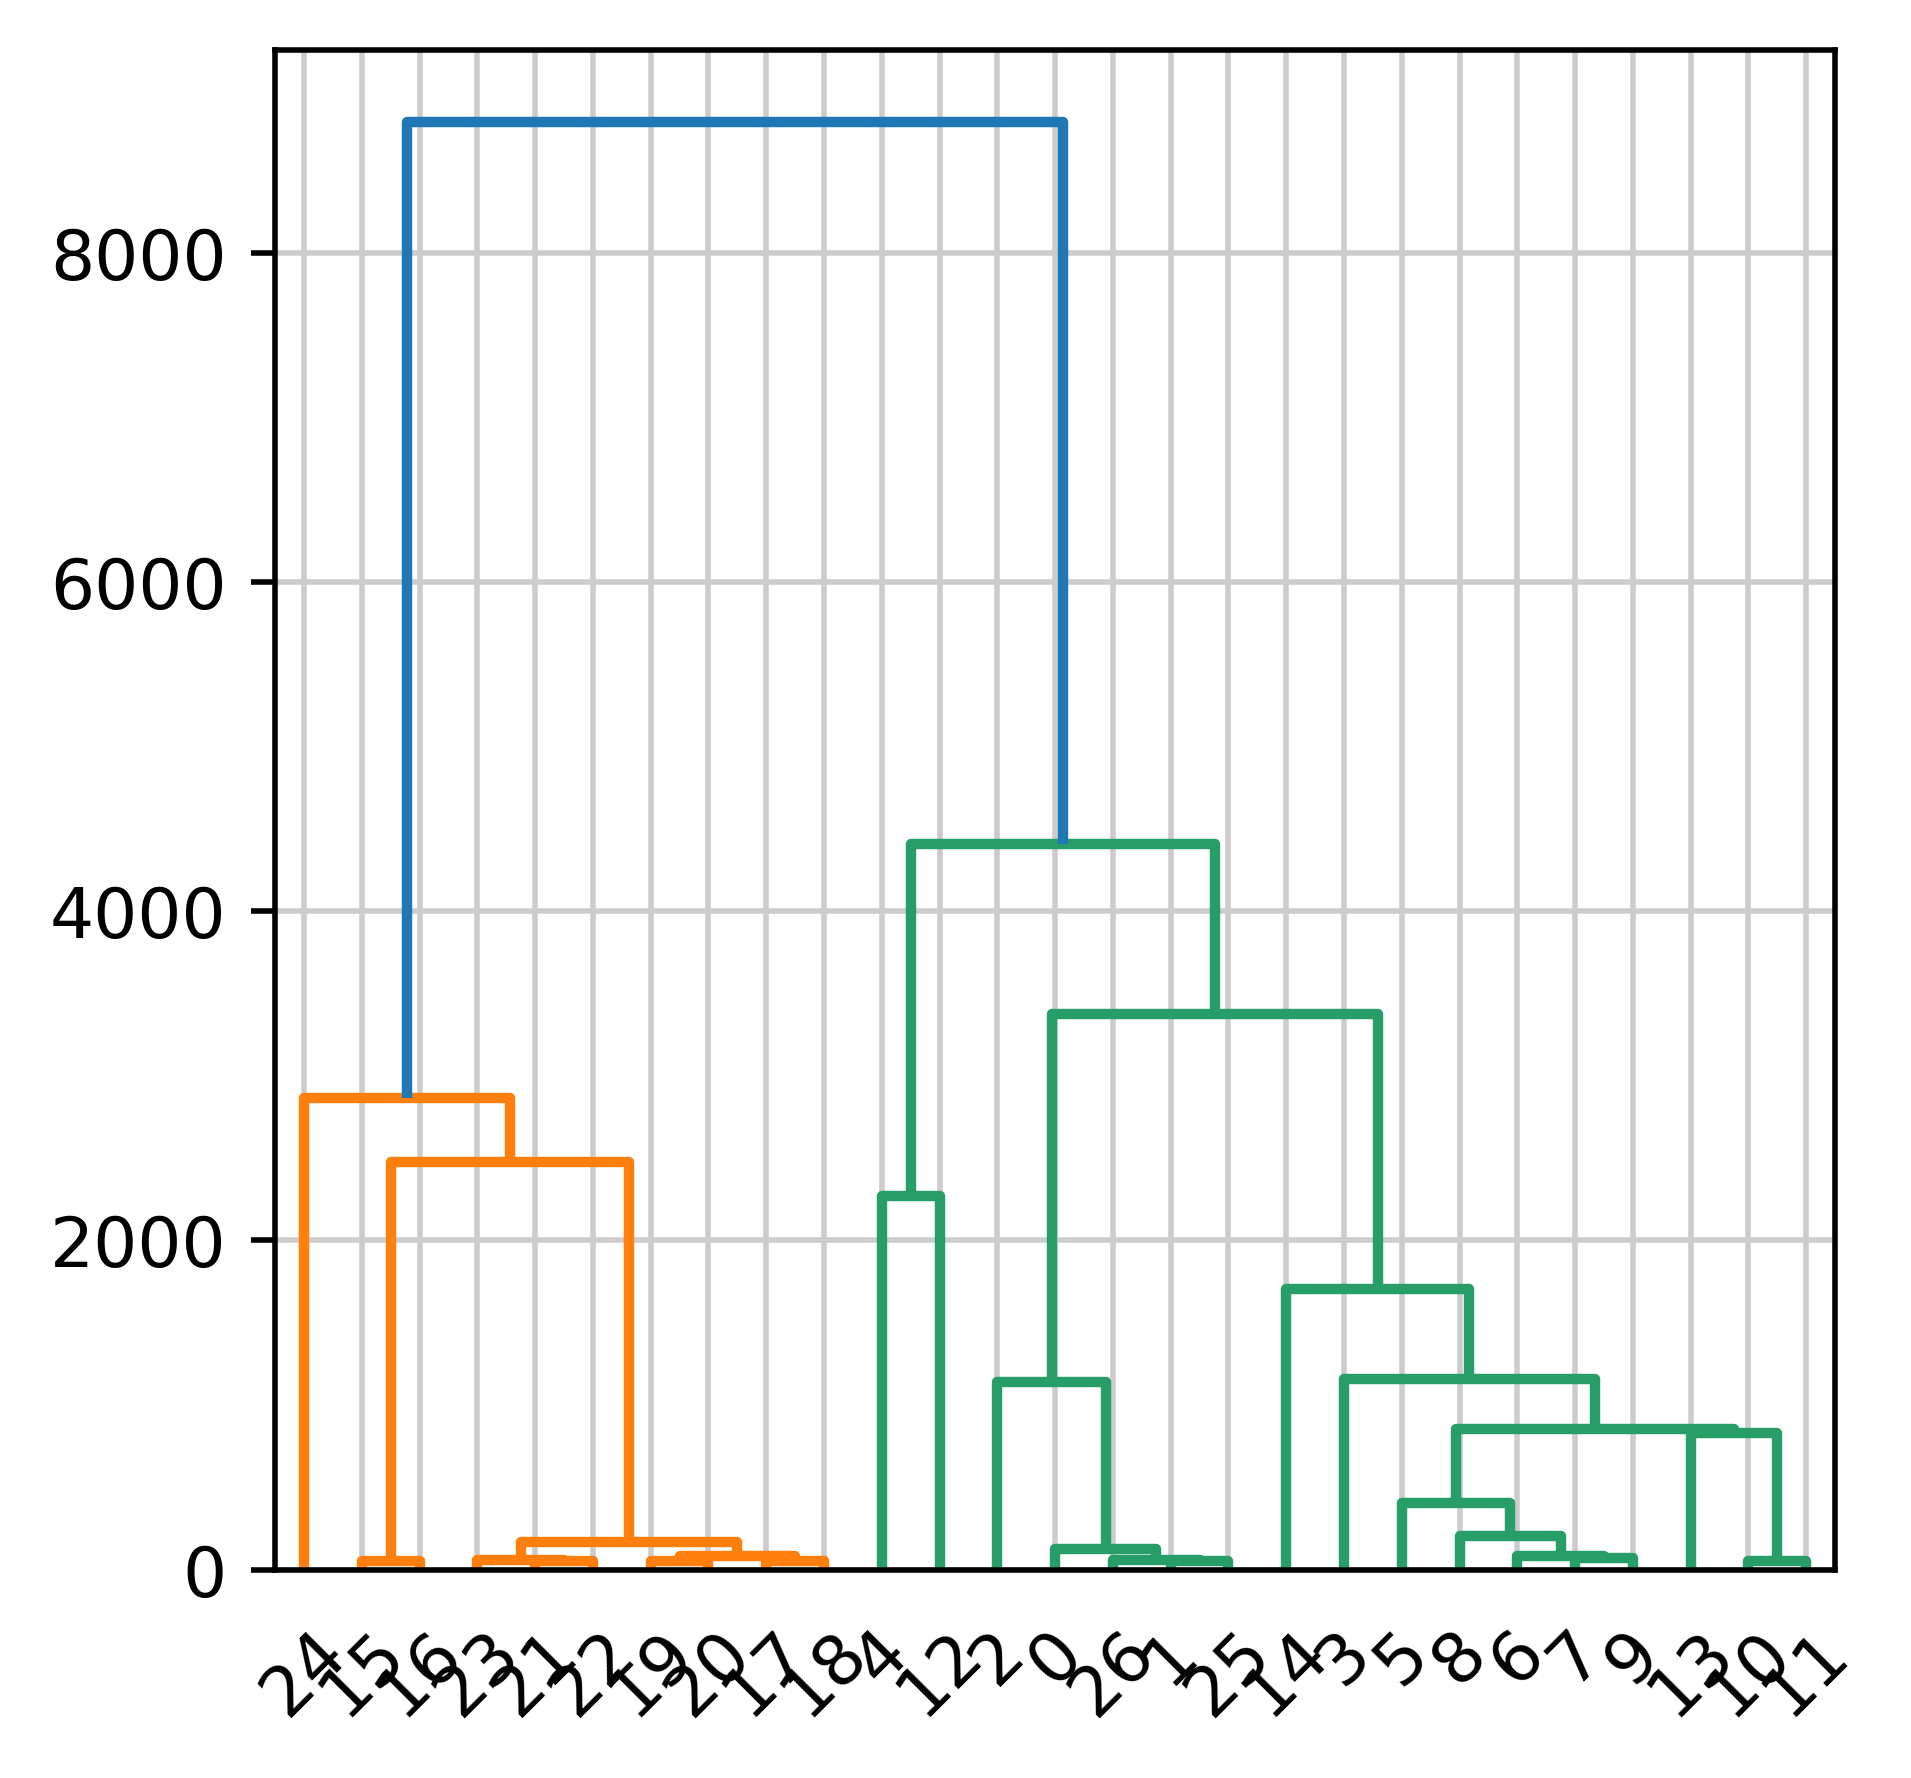

In [11]:
dendrogram(linkage_data)
plt.show()

In [12]:
# adjust n_clusters to relevant number of vessels
hierarchical_cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='single')

In [13]:
labels = hierarchical_cluster.fit_predict(data) 
print(labels)

[14  5 13  9 11 12  1  1  6  1  2  2 10  4  8  3  3  0  0  0  0  0  0  0
  7  5  5]


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [14]:
adata_aec.obs['Artery_clusters'] = labels
adata_aec.obs['Artery_clusters'] = adata_aec.obs['Artery_clusters'].astype('category')

/var/tmp/pbs.8217755.pbs/ipykernel_3428187/2590496195.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aec.obs['Artery_clusters'] = labels
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [15]:
adata_aec.obs['Artery_clusters'].value_counts()

0     7
1     3
5     3
2     2
3     2
4     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
Name: Artery_clusters, dtype: int64

In [16]:
# subset for clusters > 5 bins
adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist()

[0]

In [17]:
adata_aec_subset = adata_aec[adata_aec.obs.Artery_clusters.isin(adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist())]

In [18]:
adata_aec_subset.obs.Artery_clusters = adata_aec_subset.obs.Artery_clusters.astype(str).astype('category')

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [19]:
## adata_aec

In [20]:
#sc.pl.spatial(adata,color="VWF",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [21]:
#sc.pl.spatial(adata,color="GJA5",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [22]:
#del adata_aec.uns['Artery_clusters_colors']
#del adata_aec_subset.uns['Artery_clusters_colors']

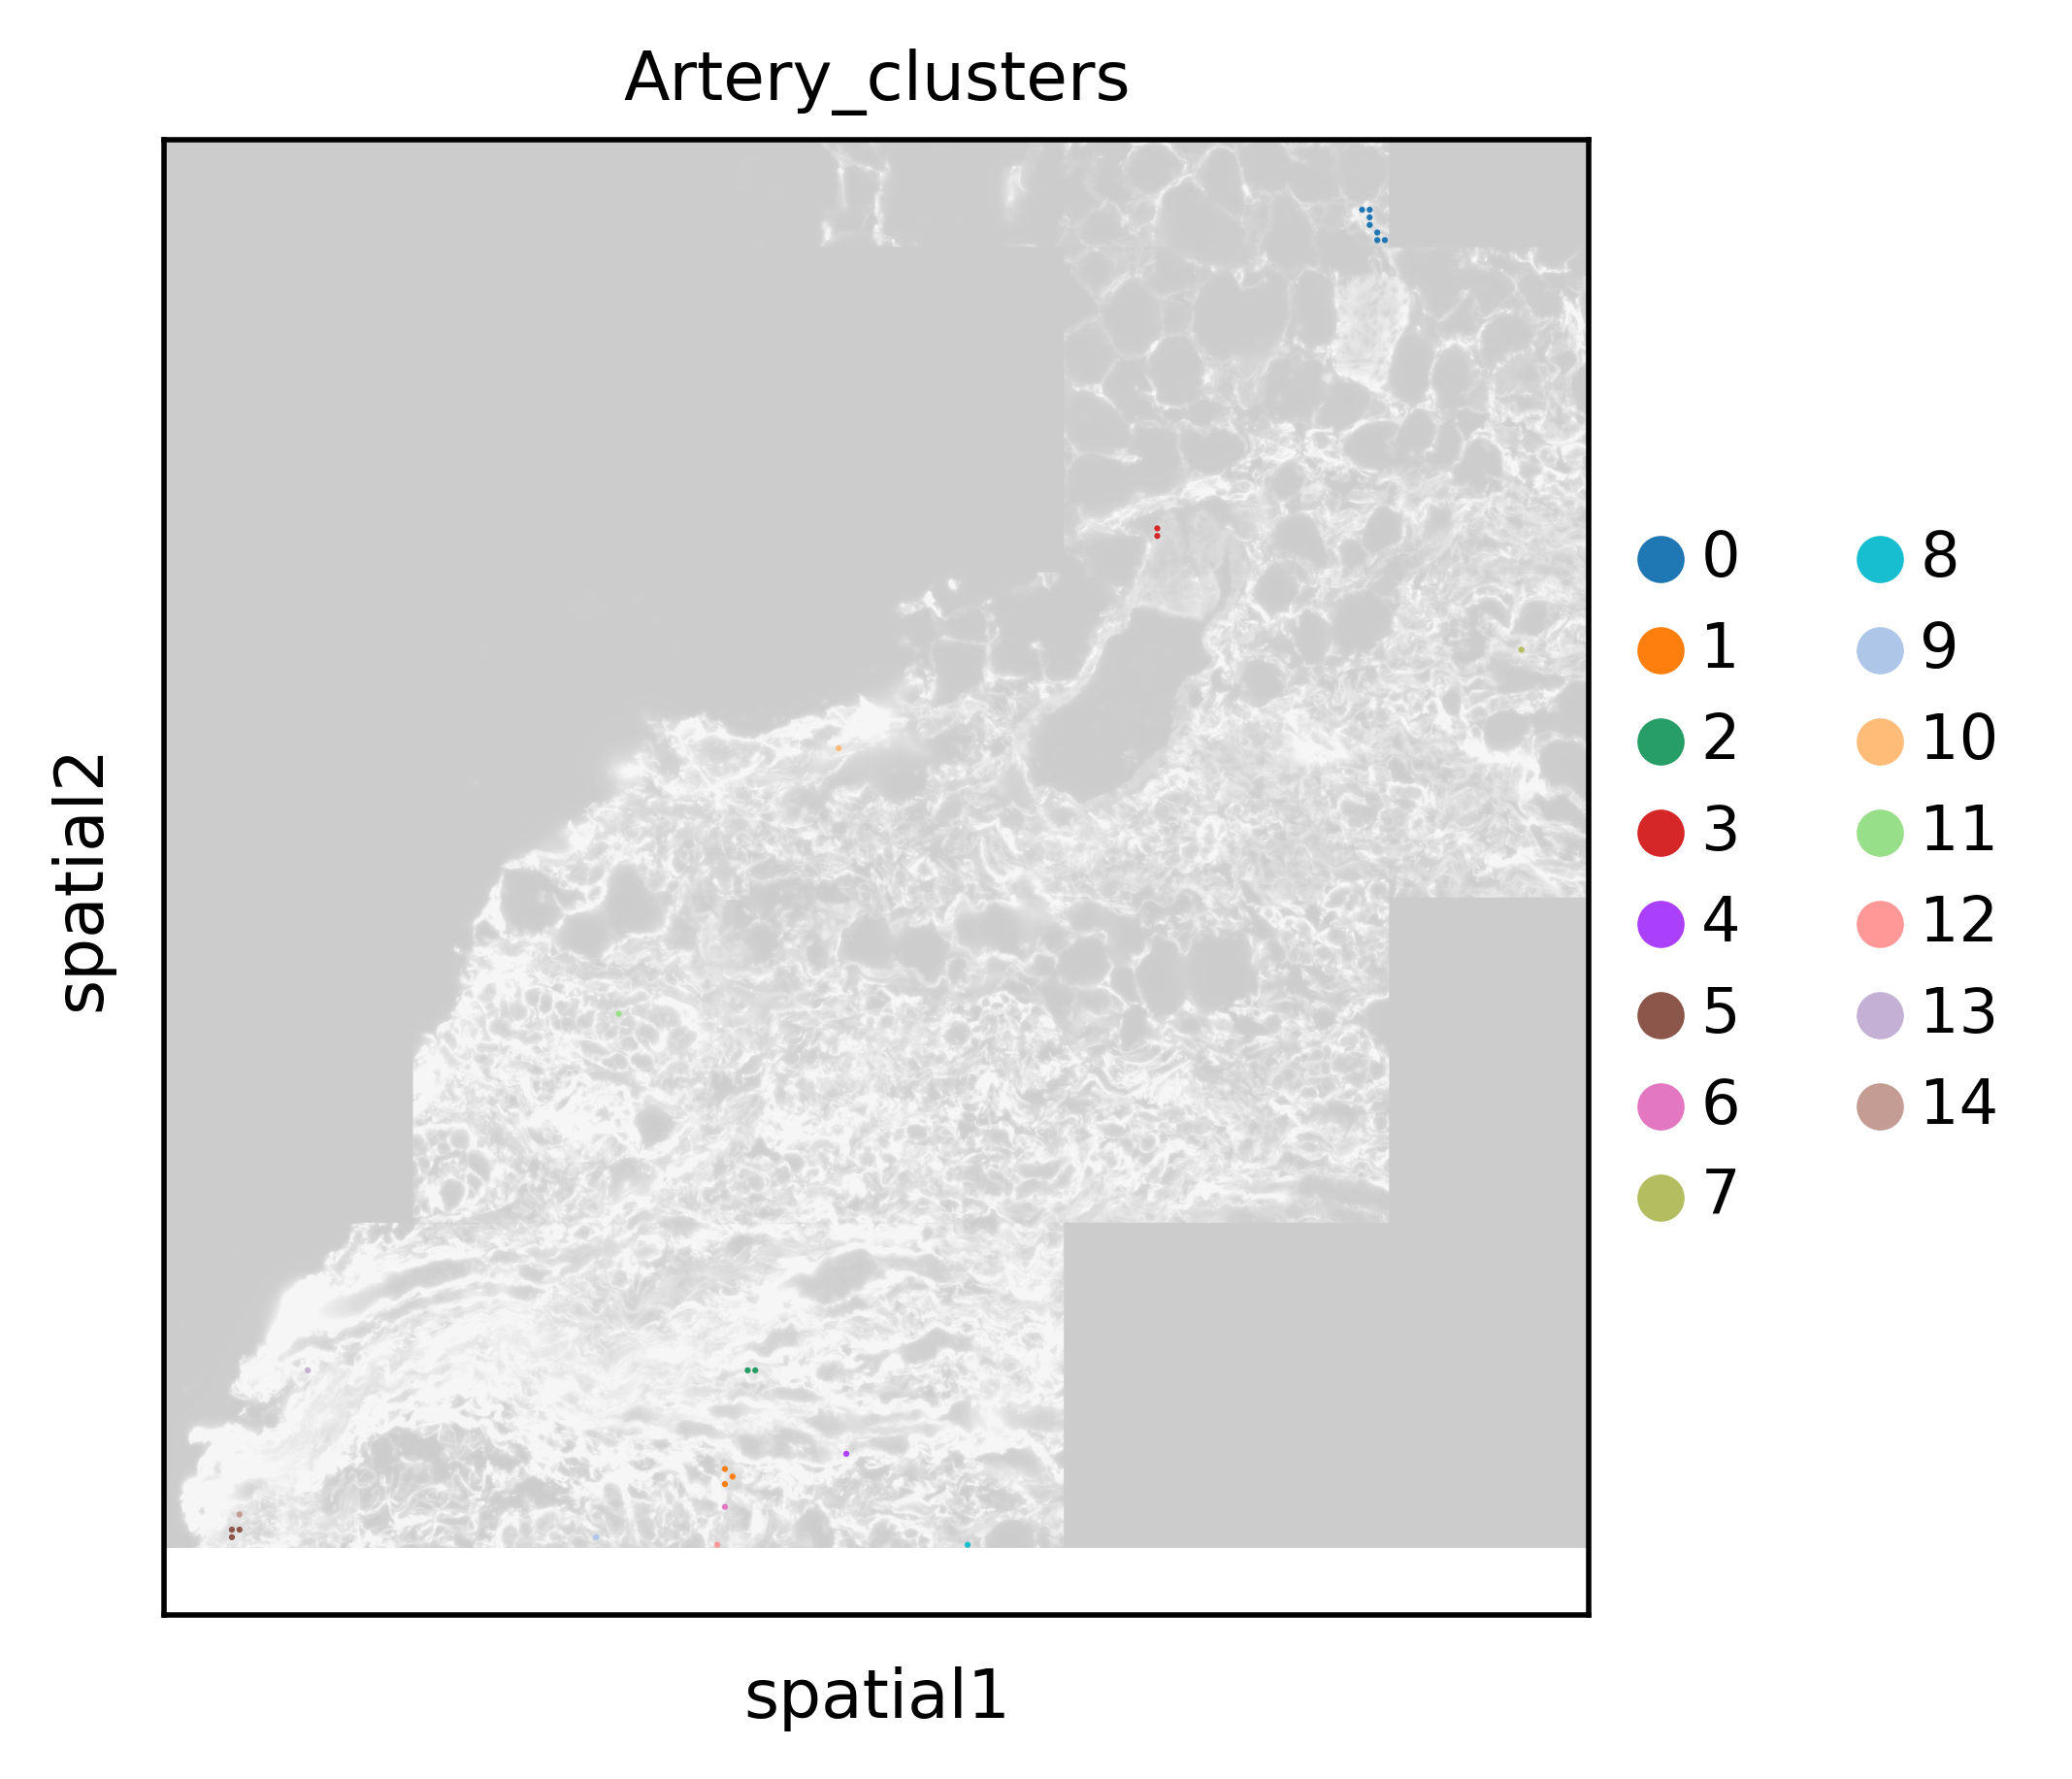

In [23]:
sc.pl.spatial(adata_aec, color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

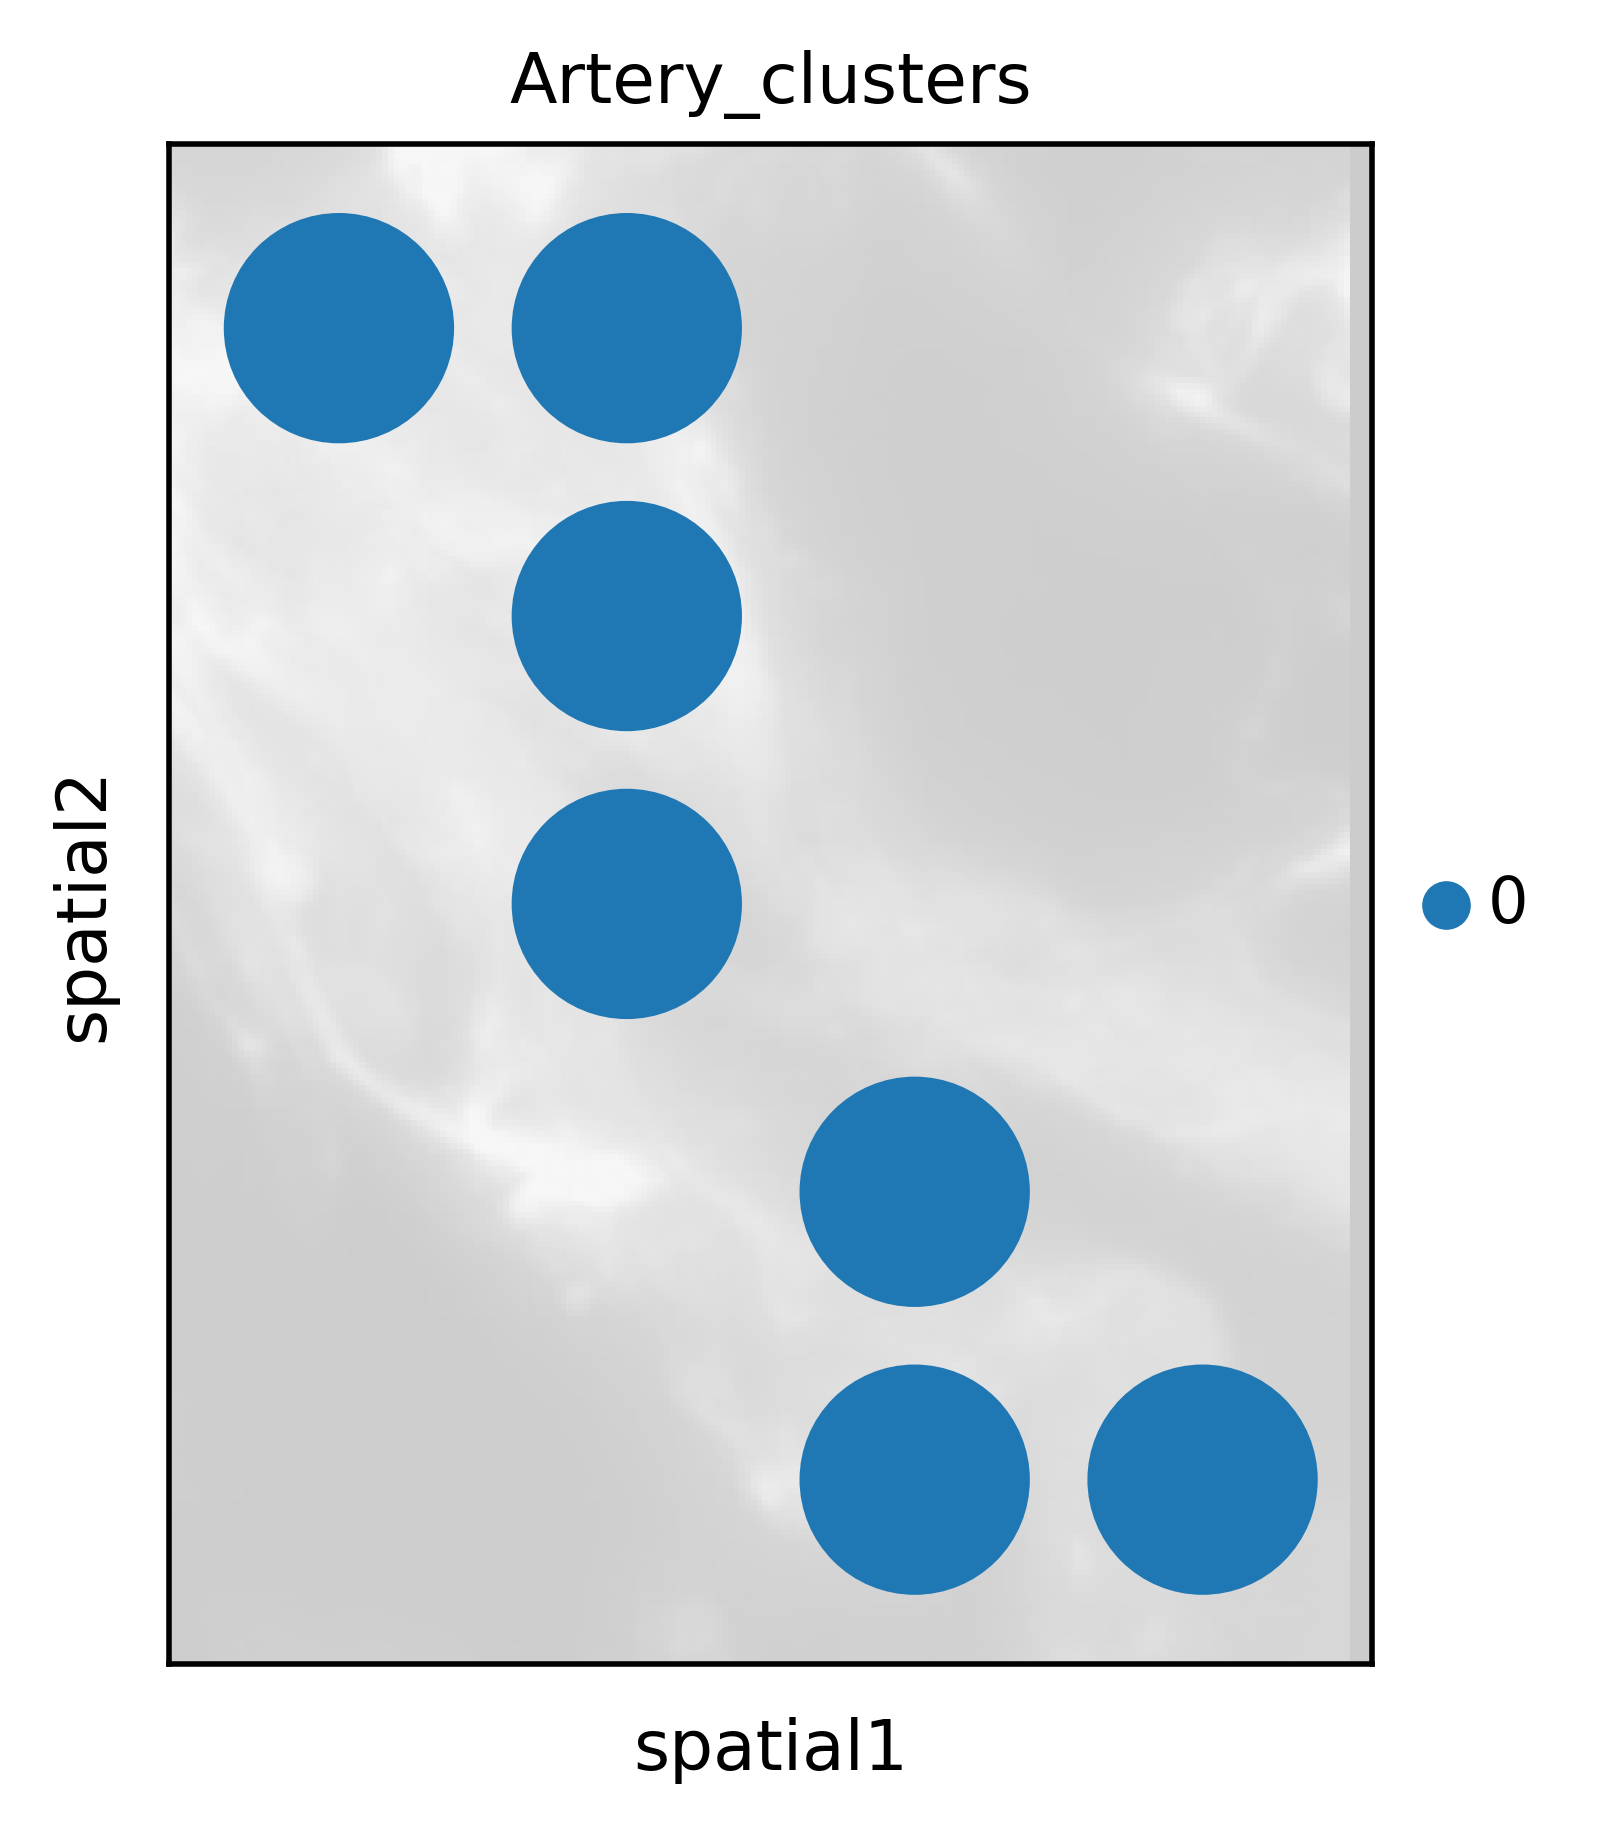

In [24]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

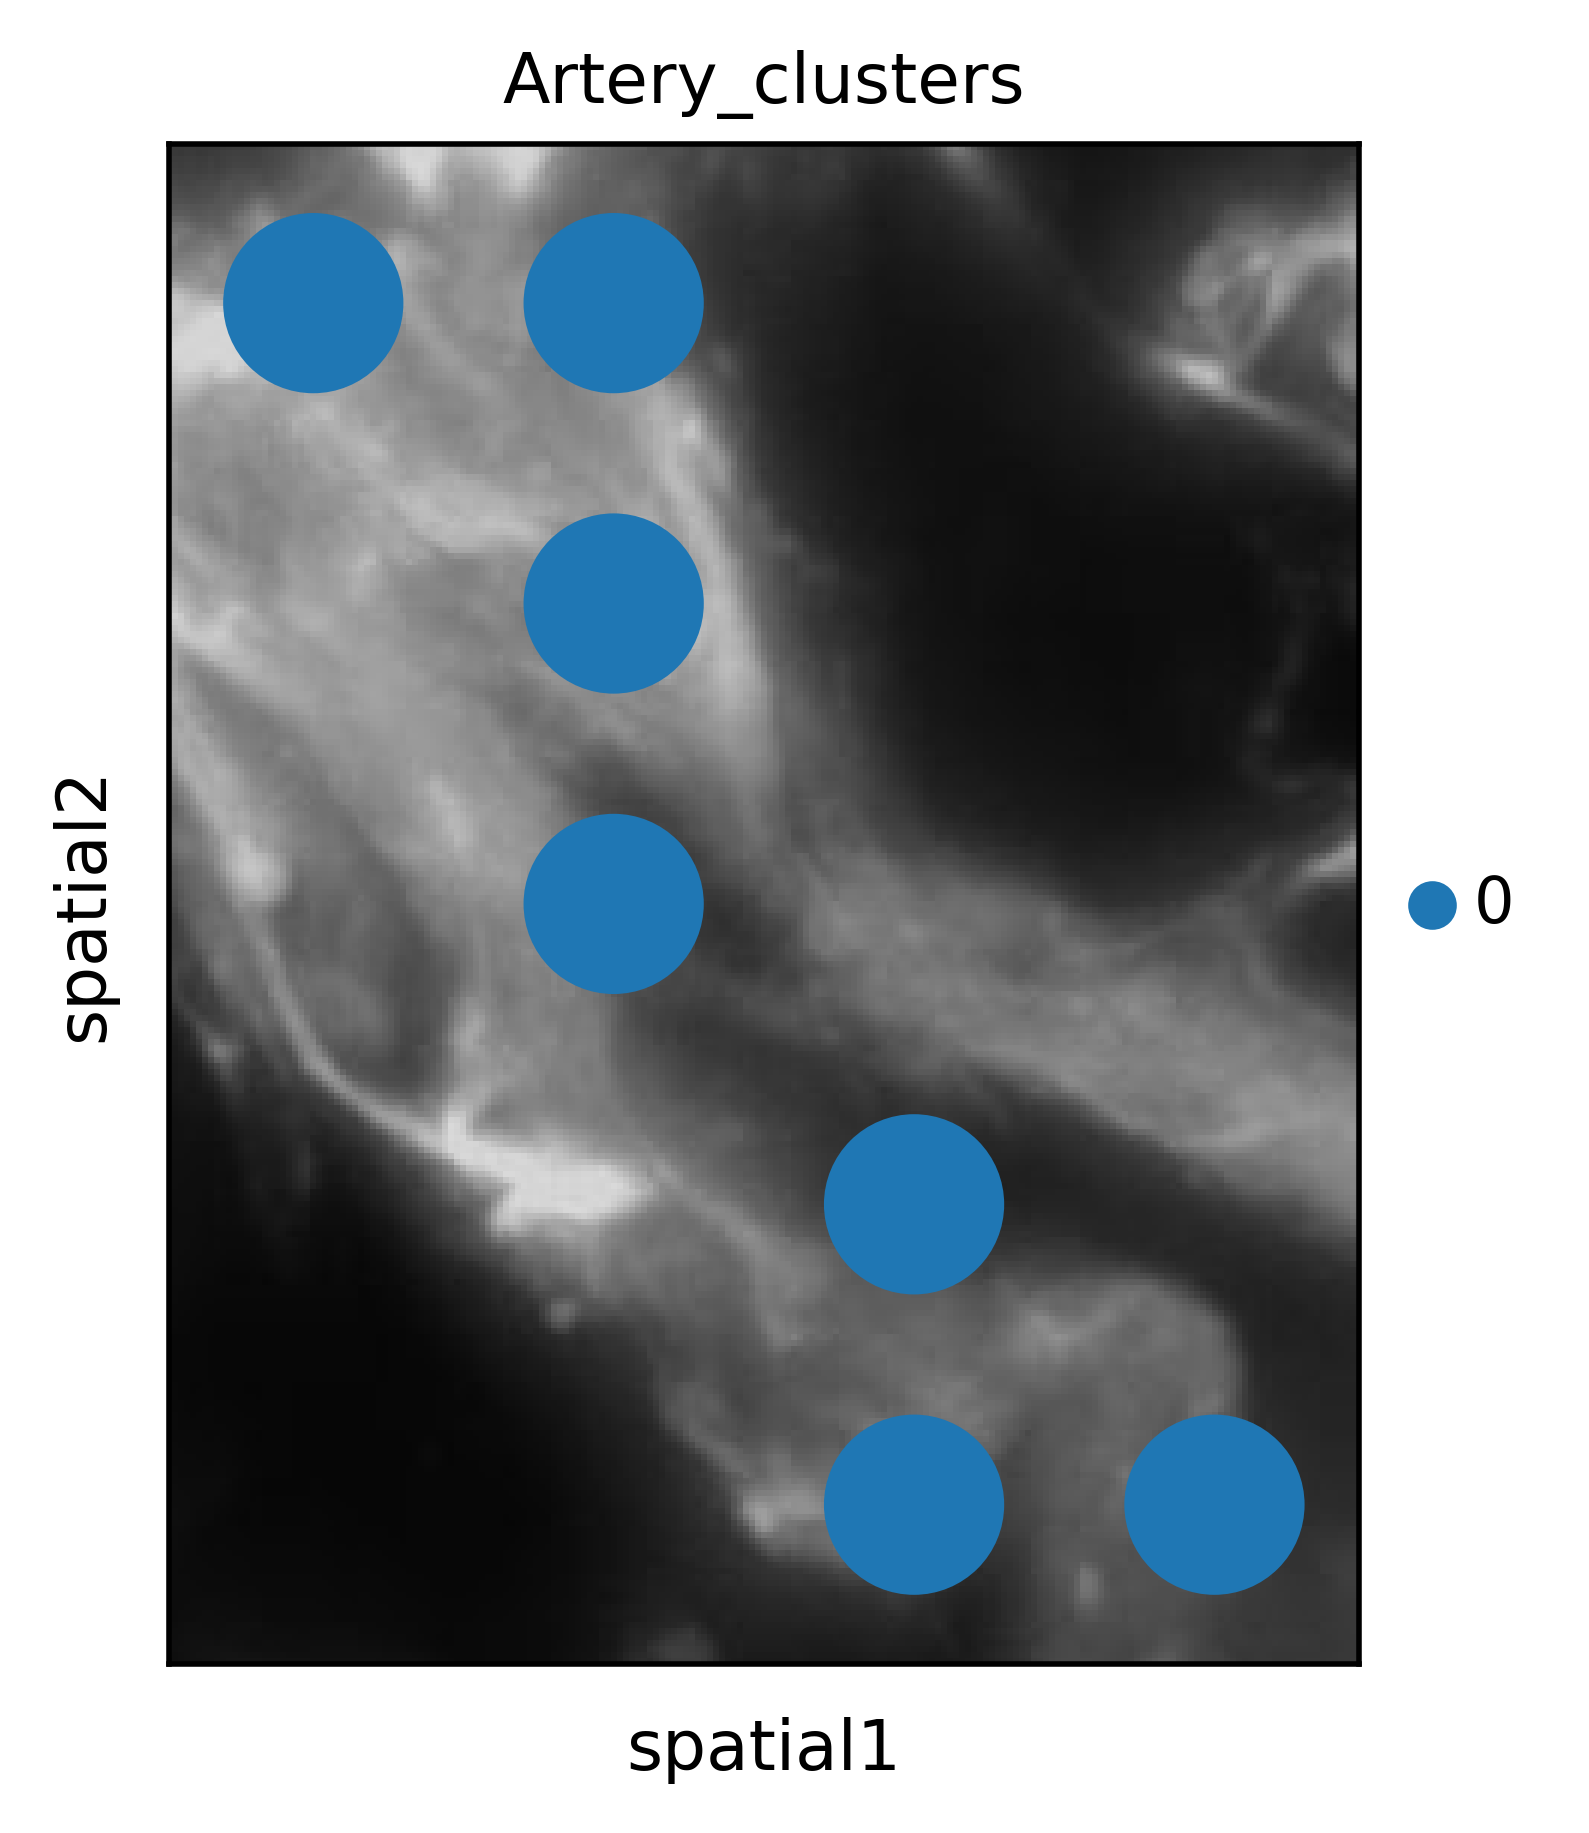

In [25]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=6)

### obtain bins percent expressing values

In [19]:
adata_aec_subset.obs['SULF1_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 1)

In [20]:
adata_aec_subset.obs['NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 1)

In [21]:
adata_aec_subset.obs['SEMA3G_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SEMA3G'] > 0)

In [22]:
adata_aec_subset.obs['RGCC_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='RGCC'] > 0)

In [23]:
adata_aec_subset.obs['SULF1+NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 1)

In [24]:
adata_aec_subset

AnnData object with n_obs × n_vars = 7 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters', 'SULF1_percent', 'NEBL_percent', 'SEMA3G_percent', 'RGCC_percent', 'SULF1+NEBL_percent'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [25]:
results = adata_aec_subset.obs[['SULF1+NEBL_percent','SULF1_percent','NEBL_percent','SEMA3G_percent','RGCC_percent','Artery_clusters']].groupby('Artery_clusters').mean()

In [26]:
results

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent
Artery_clusters,,,,,
0,0.0,0.285714,0.0,0.0,0.0


### obtain mean expression (all bins / cluster)

In [27]:
matrix=pd.DataFrame(adata_aec_subset.X,columns=adata_aec_subset.raw.var.index,index=adata_aec_subset.obs.index)

In [28]:
matrix["Artery_clusters"] = adata_aec_subset.obs["Artery_clusters"]

In [29]:
df_mean=matrix.groupby("Artery_clusters").mean()

In [30]:
df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,
0,1.0,0.0,0.0,0.0


### obtain mean expression (expressing bins only / cluster)

In [31]:
matrix2 = matrix.replace(0, np.NaN)

In [32]:
df_mean_nonzero =matrix2.groupby("Artery_clusters").mean()

In [33]:
df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,
0,1.75,NaN,NaN,NaN


### add expression values to dataframe

In [34]:
#mean expression (all bins / cluster)
test = pd.concat([results, df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [35]:
test

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,
0,0.0,0.285714,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
#mean expression (expressing bins only / cluster)
test2 = pd.concat([results, df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [37]:
test2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,
0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN


In [38]:
test2.rename(columns={"SULF1": "SULF1_mean", "NEBL": "NEBL_mean", "SEMA3G": "SEMA3G_mean", "RGCC": "RGCC_mean"}, inplace = True)

In [39]:
test2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean
Artery_clusters,,,,,,,,,
0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN


## add raw values

In [40]:
df_sum=matrix.groupby("Artery_clusters").sum()

In [41]:
df_sum[["SULF1","NEBL","SEMA3G","RGCC","GJA5"]]

Genes,SULF1,NEBL,SEMA3G,RGCC,GJA5
Artery_clusters,,,,,
0,7.0,0.0,0.0,0.0,34.0


In [42]:
test3 = pd.concat([test2, df_sum[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [43]:
test3

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,,,,,
0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN,7.0,0.0,0.0,0.0


### add cluster size (no. bins / vessel)

In [44]:
results2 = test3.join(adata_aec_subset.obs['Artery_clusters'].value_counts(), on=None, how='left', lsuffix='', rsuffix='', sort=False, validate=None)

In [45]:
results2.columns = list(results2.columns[0:13]) + ['size']

In [46]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size
Artery_clusters,,,,,,,,,,,,,,
0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN,7.0,0.0,0.0,0.0,7


### add ROI numbers

In [47]:
results2.index = ['ROI_C2-3_' + str(i) for i in results2.index.tolist()]

In [48]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size
ROI_C2-3_0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN,7.0,0.0,0.0,0.0,7


In [49]:
results2["ROI"] = "C2-3"

In [50]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size,ROI
ROI_C2-3_0,0.0,0.285714,0.0,0.0,0.0,1.75,NaN,NaN,NaN,7.0,0.0,0.0,0.0,7,C2-3


In [51]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/ROI_df/C2-3.csv")

### define size group (small / large)

In [50]:
# remove undesired vessels here (i.e. at edge of frame)

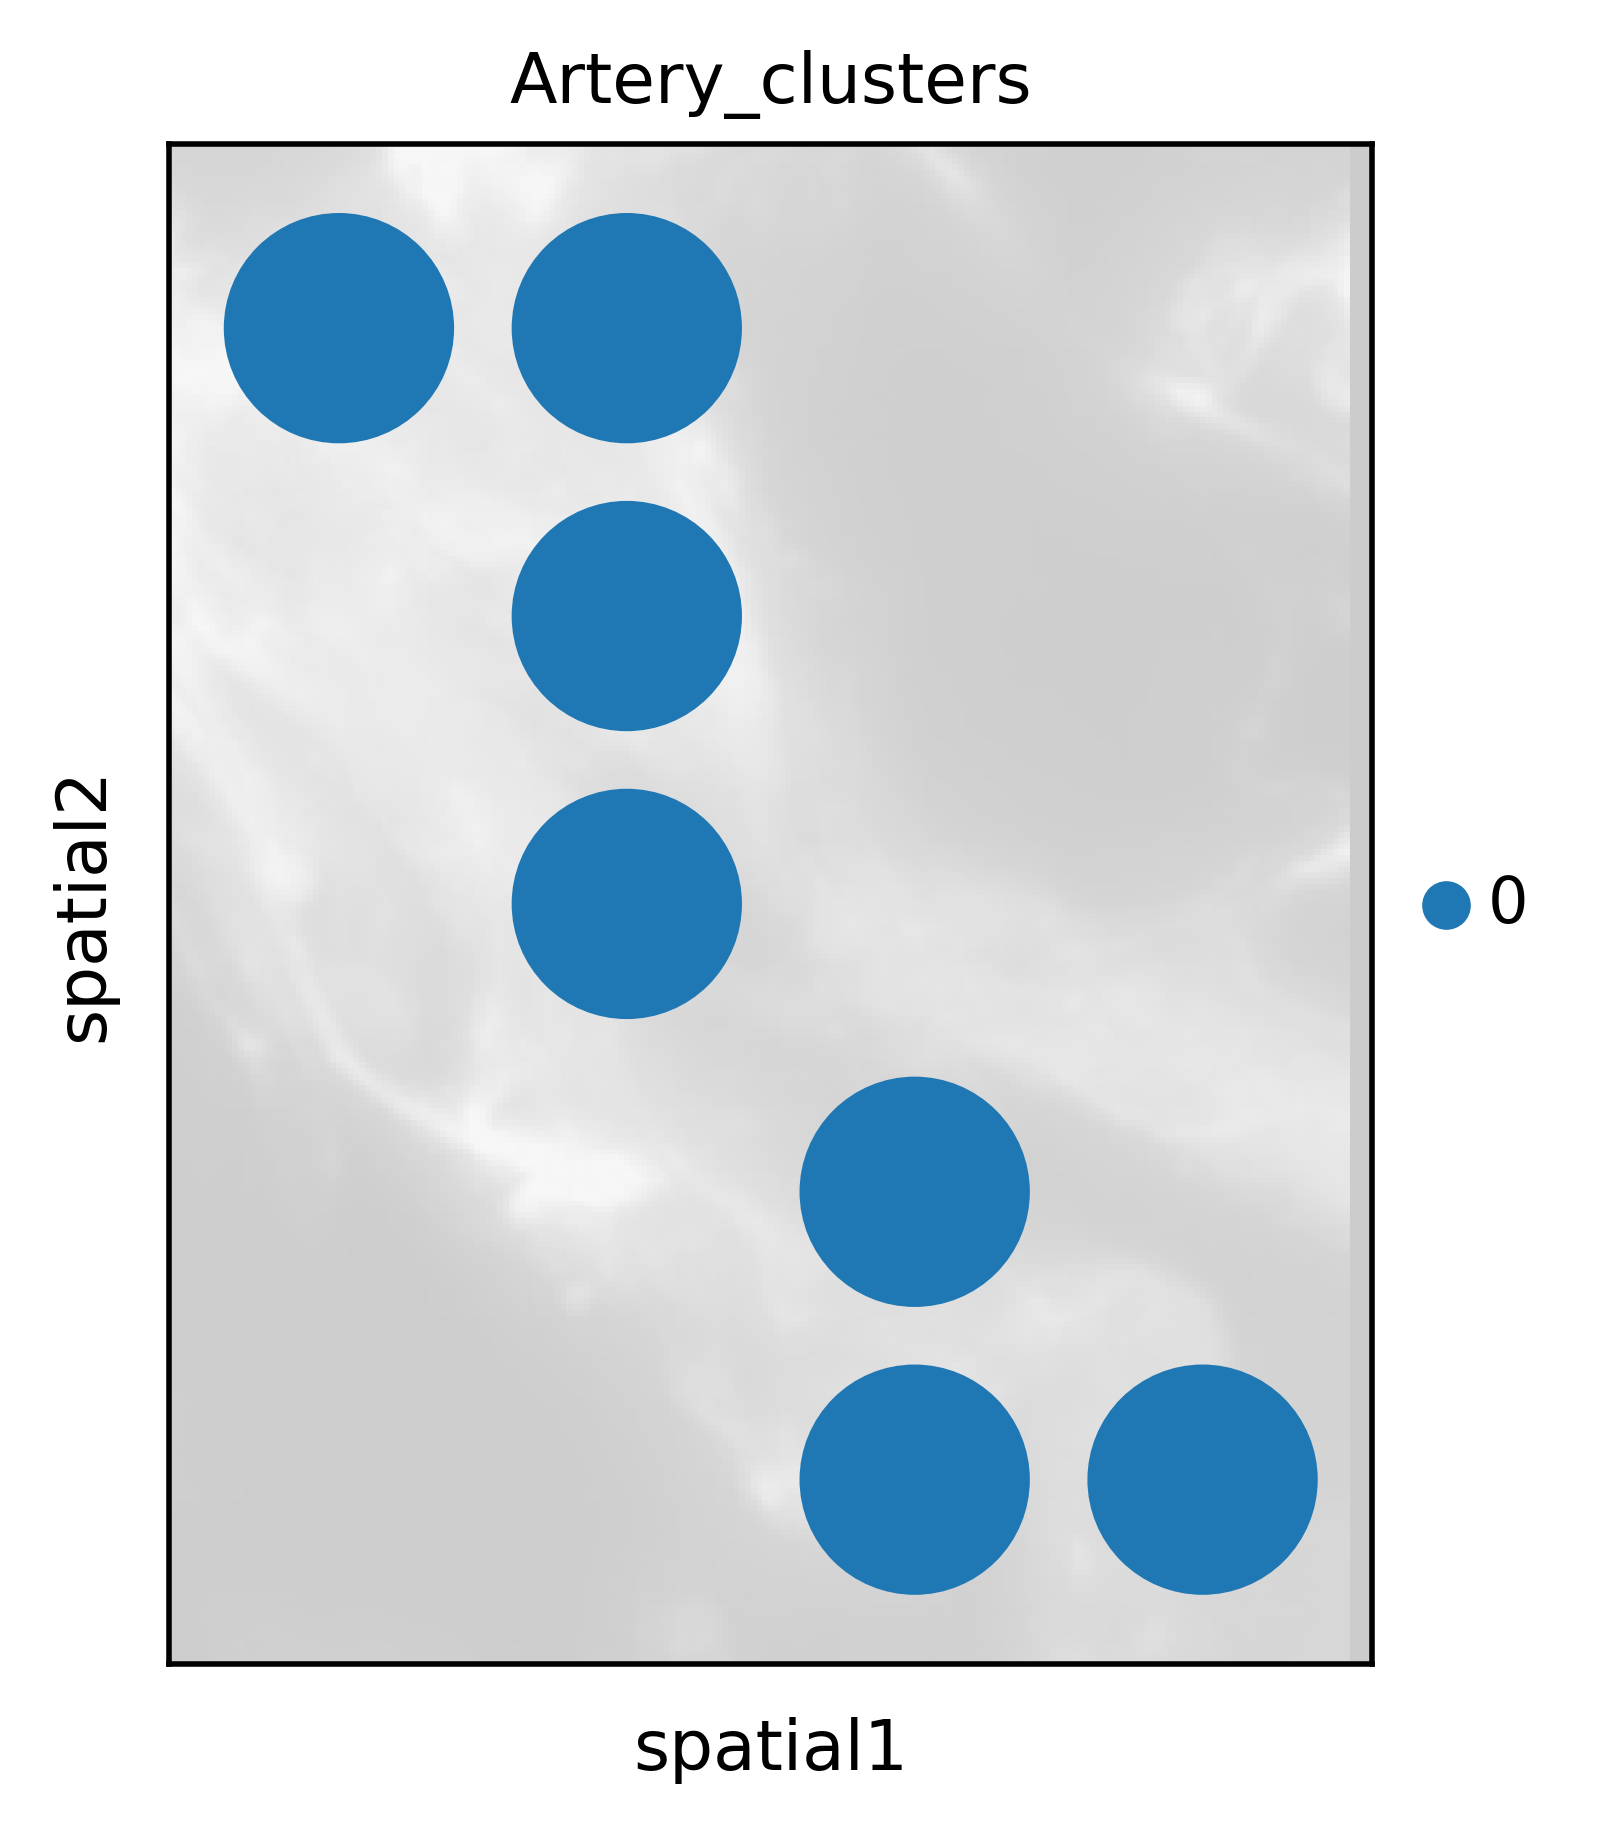

In [51]:
sc.pl.spatial(adata_aec_subset,color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

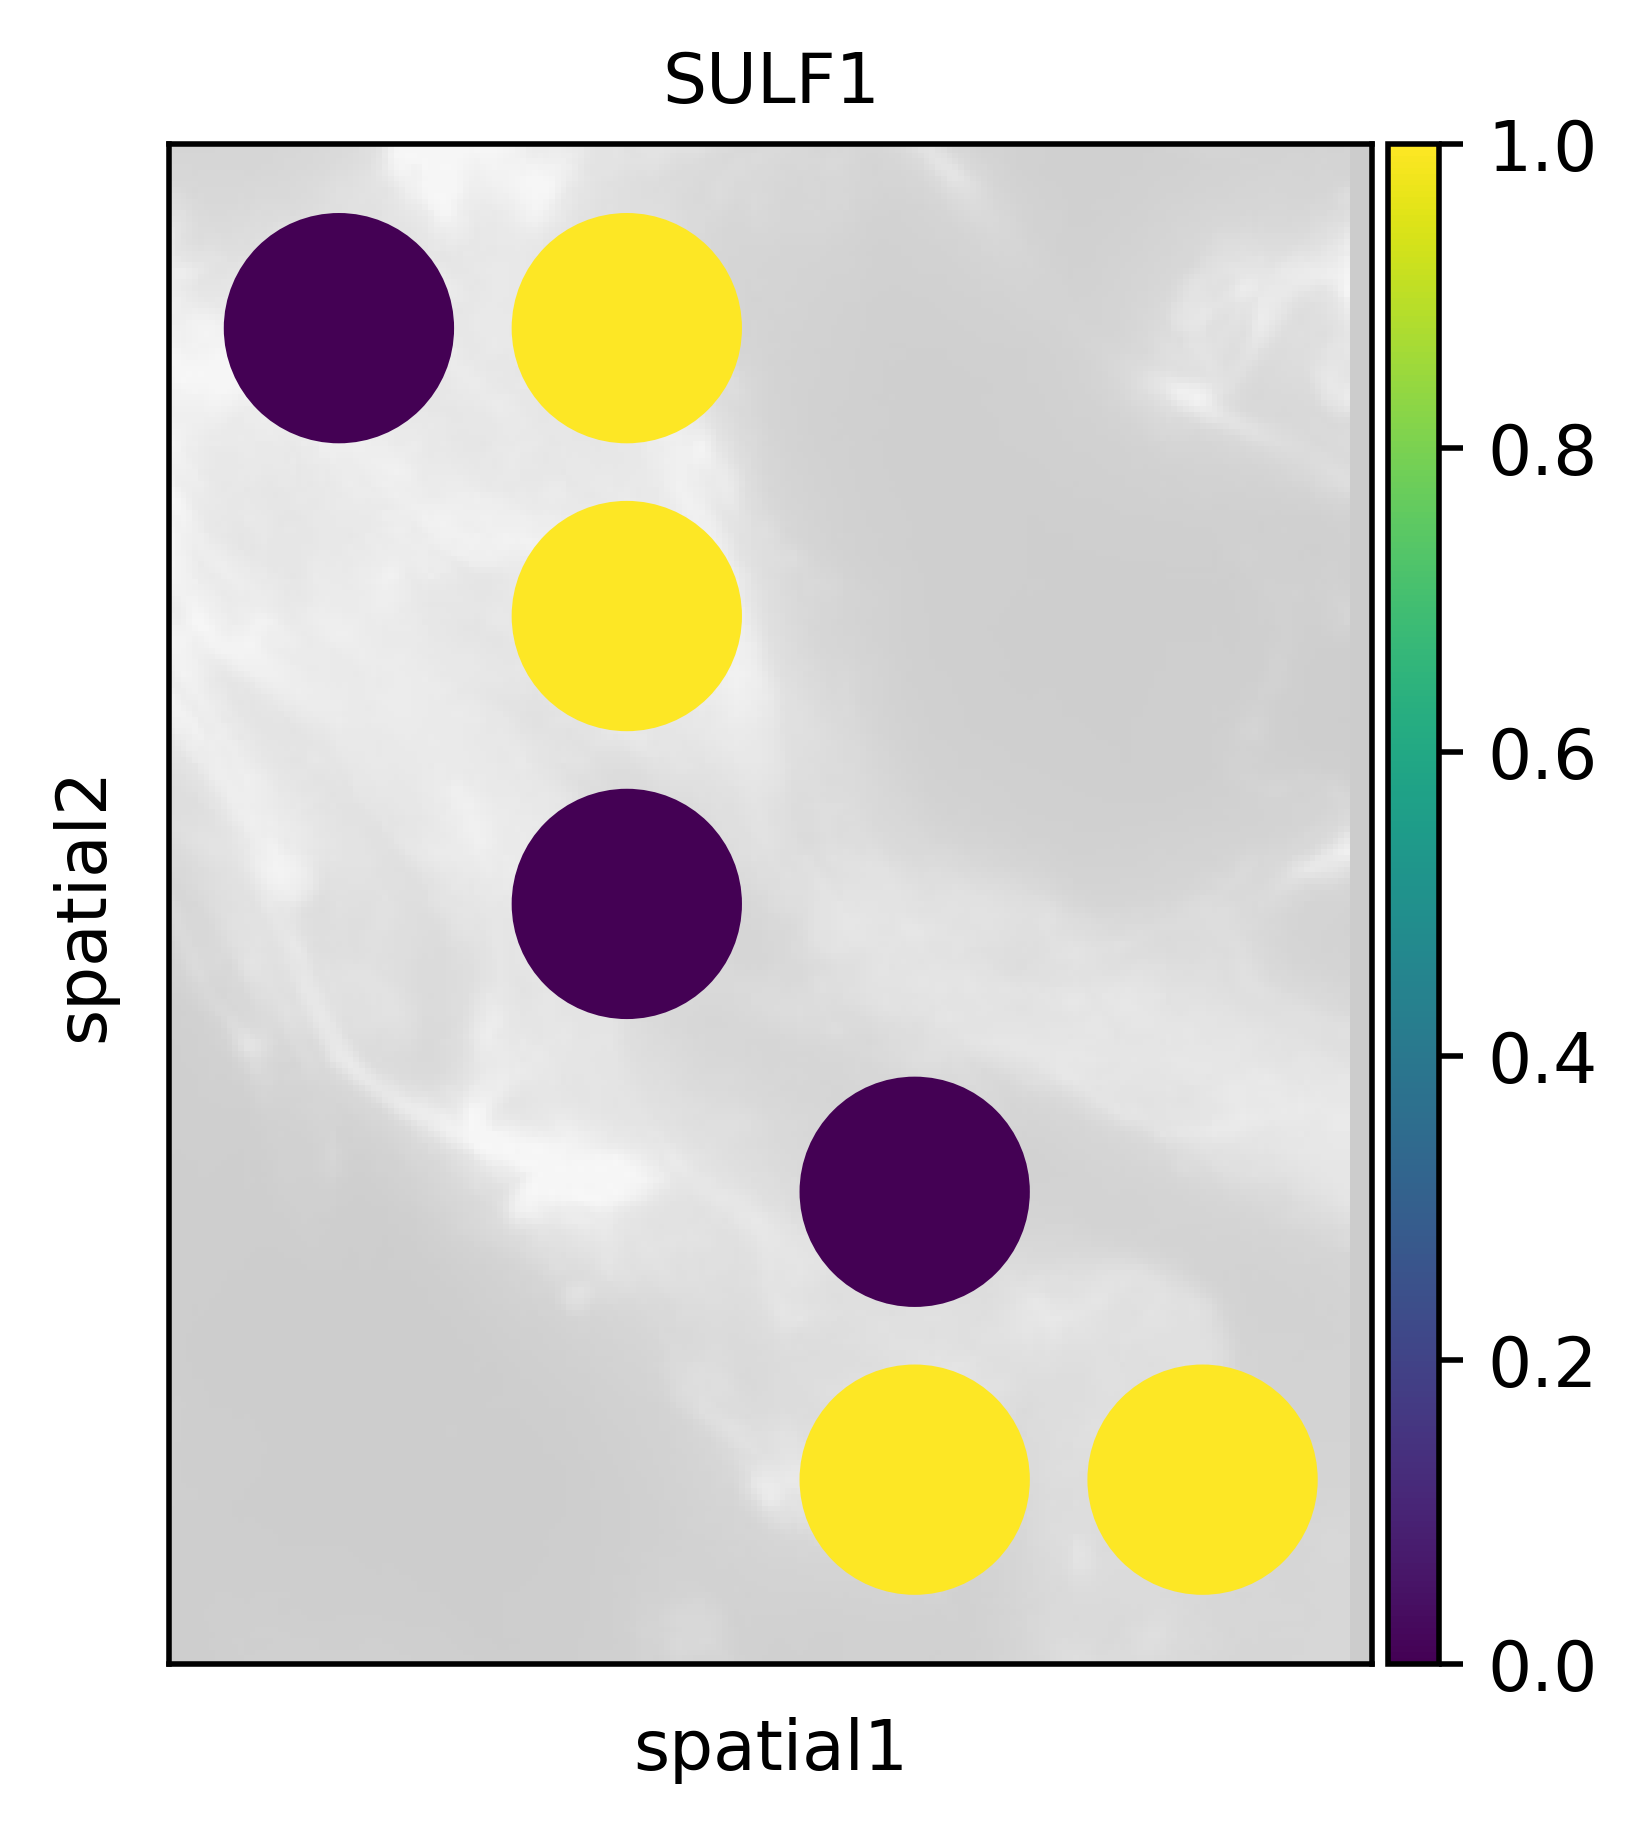

In [52]:
sc.pl.spatial(adata_aec_subset,color="SULF1",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [53]:
group=pd.Series("Large", index=results2.index)

In [54]:
group[results2["size"] <= 30] = "Small"

In [55]:
group

ROI_C2-3_0    Small
dtype: object

In [56]:
results2["group"] = group

In [60]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/C2-3.csv")

In [58]:
#results2.drop(["ROI_A2-1_25"])

In [59]:
### calculate mean / group

In [55]:
results3 = results2.groupby("group").mean()

/var/tmp/pbs.7693052.pbs/ipykernel_874973/424135287.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results3 = results2.groupby("group").mean()


In [56]:
results3["ROI"] = 'C2-3'

In [57]:
results3

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SULF1,NEBL,SEMA3G,RGCC,size,ROI
group,,,,,,,,,
Small,0.0,0.285714,0.0,1.75,NaN,NaN,NaN,7.0,C2-3


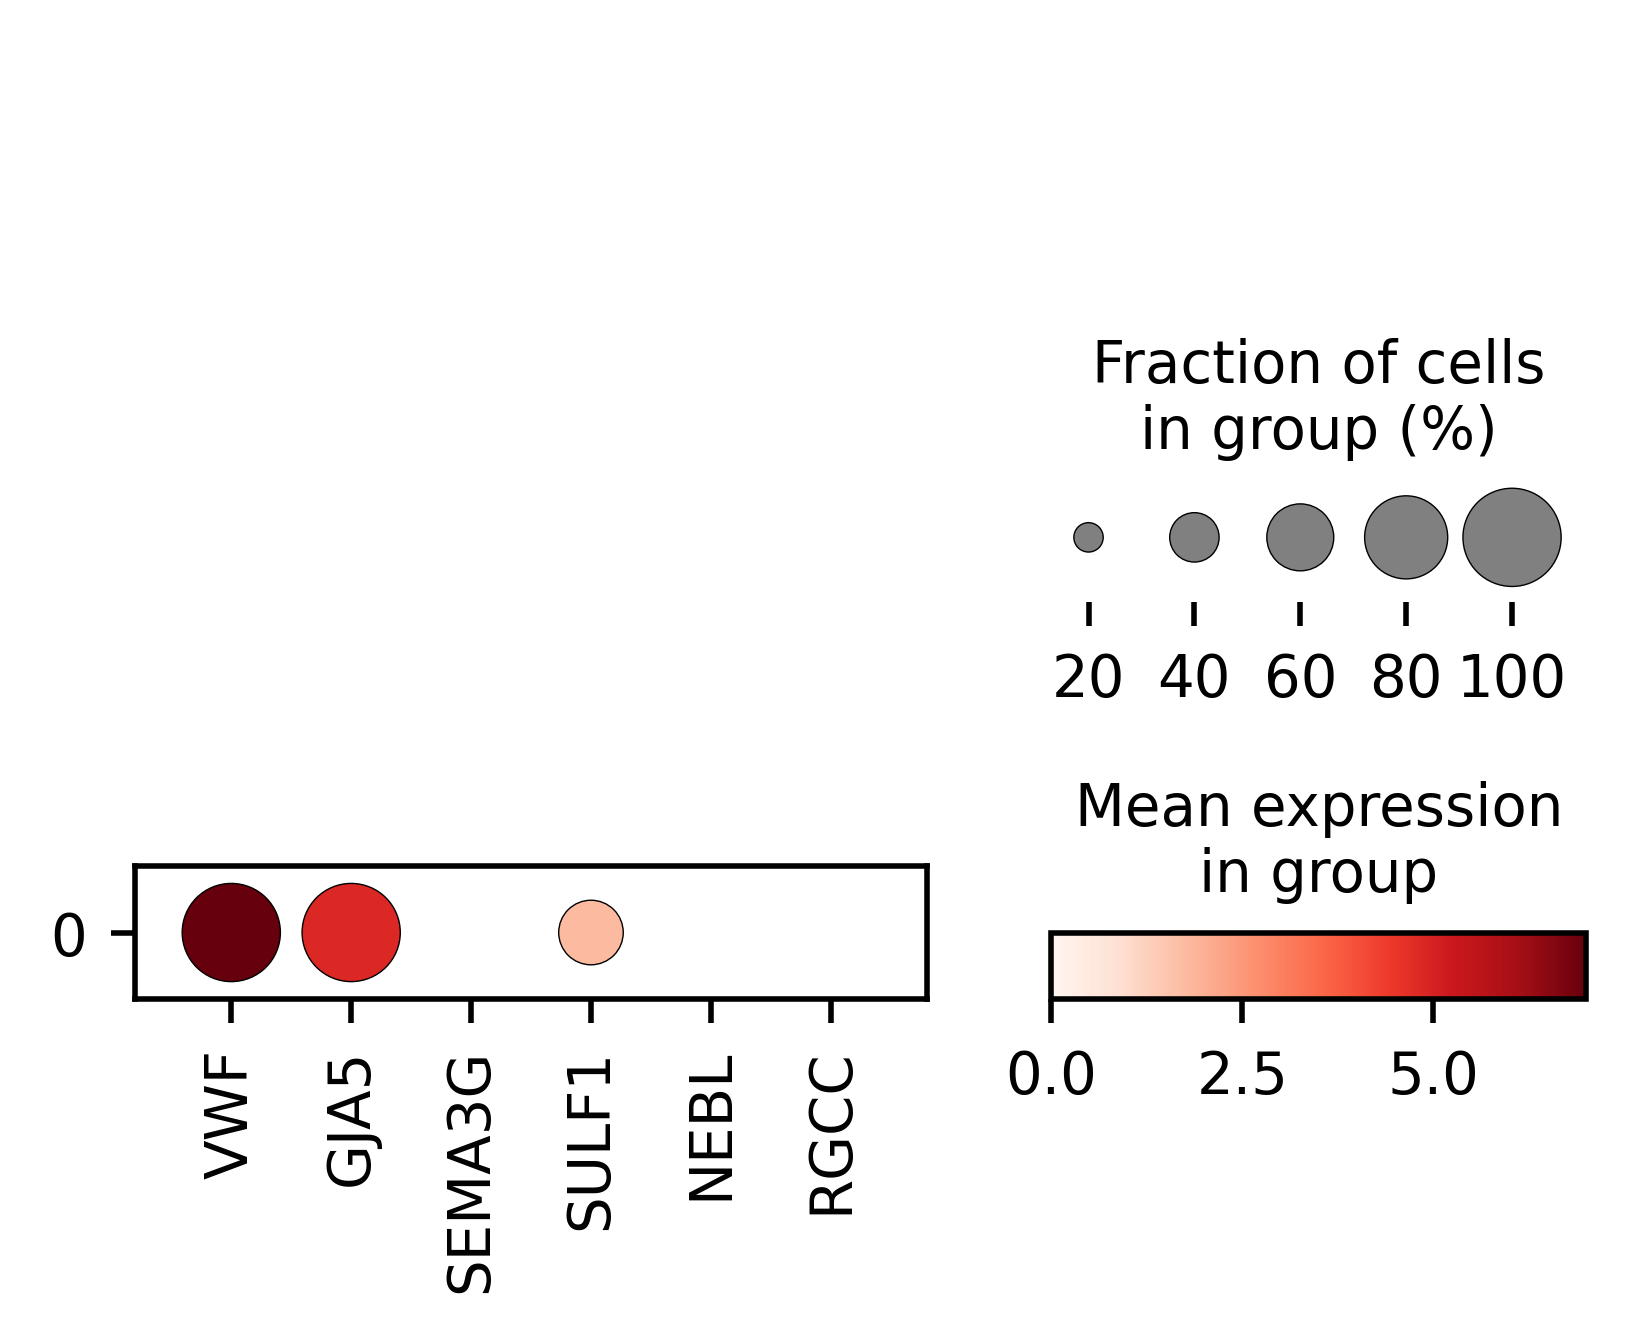

In [58]:
markers = ["VWF","GJA5","SEMA3G","SULF1","NEBL","RGCC"]
sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = True)
#sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = False)

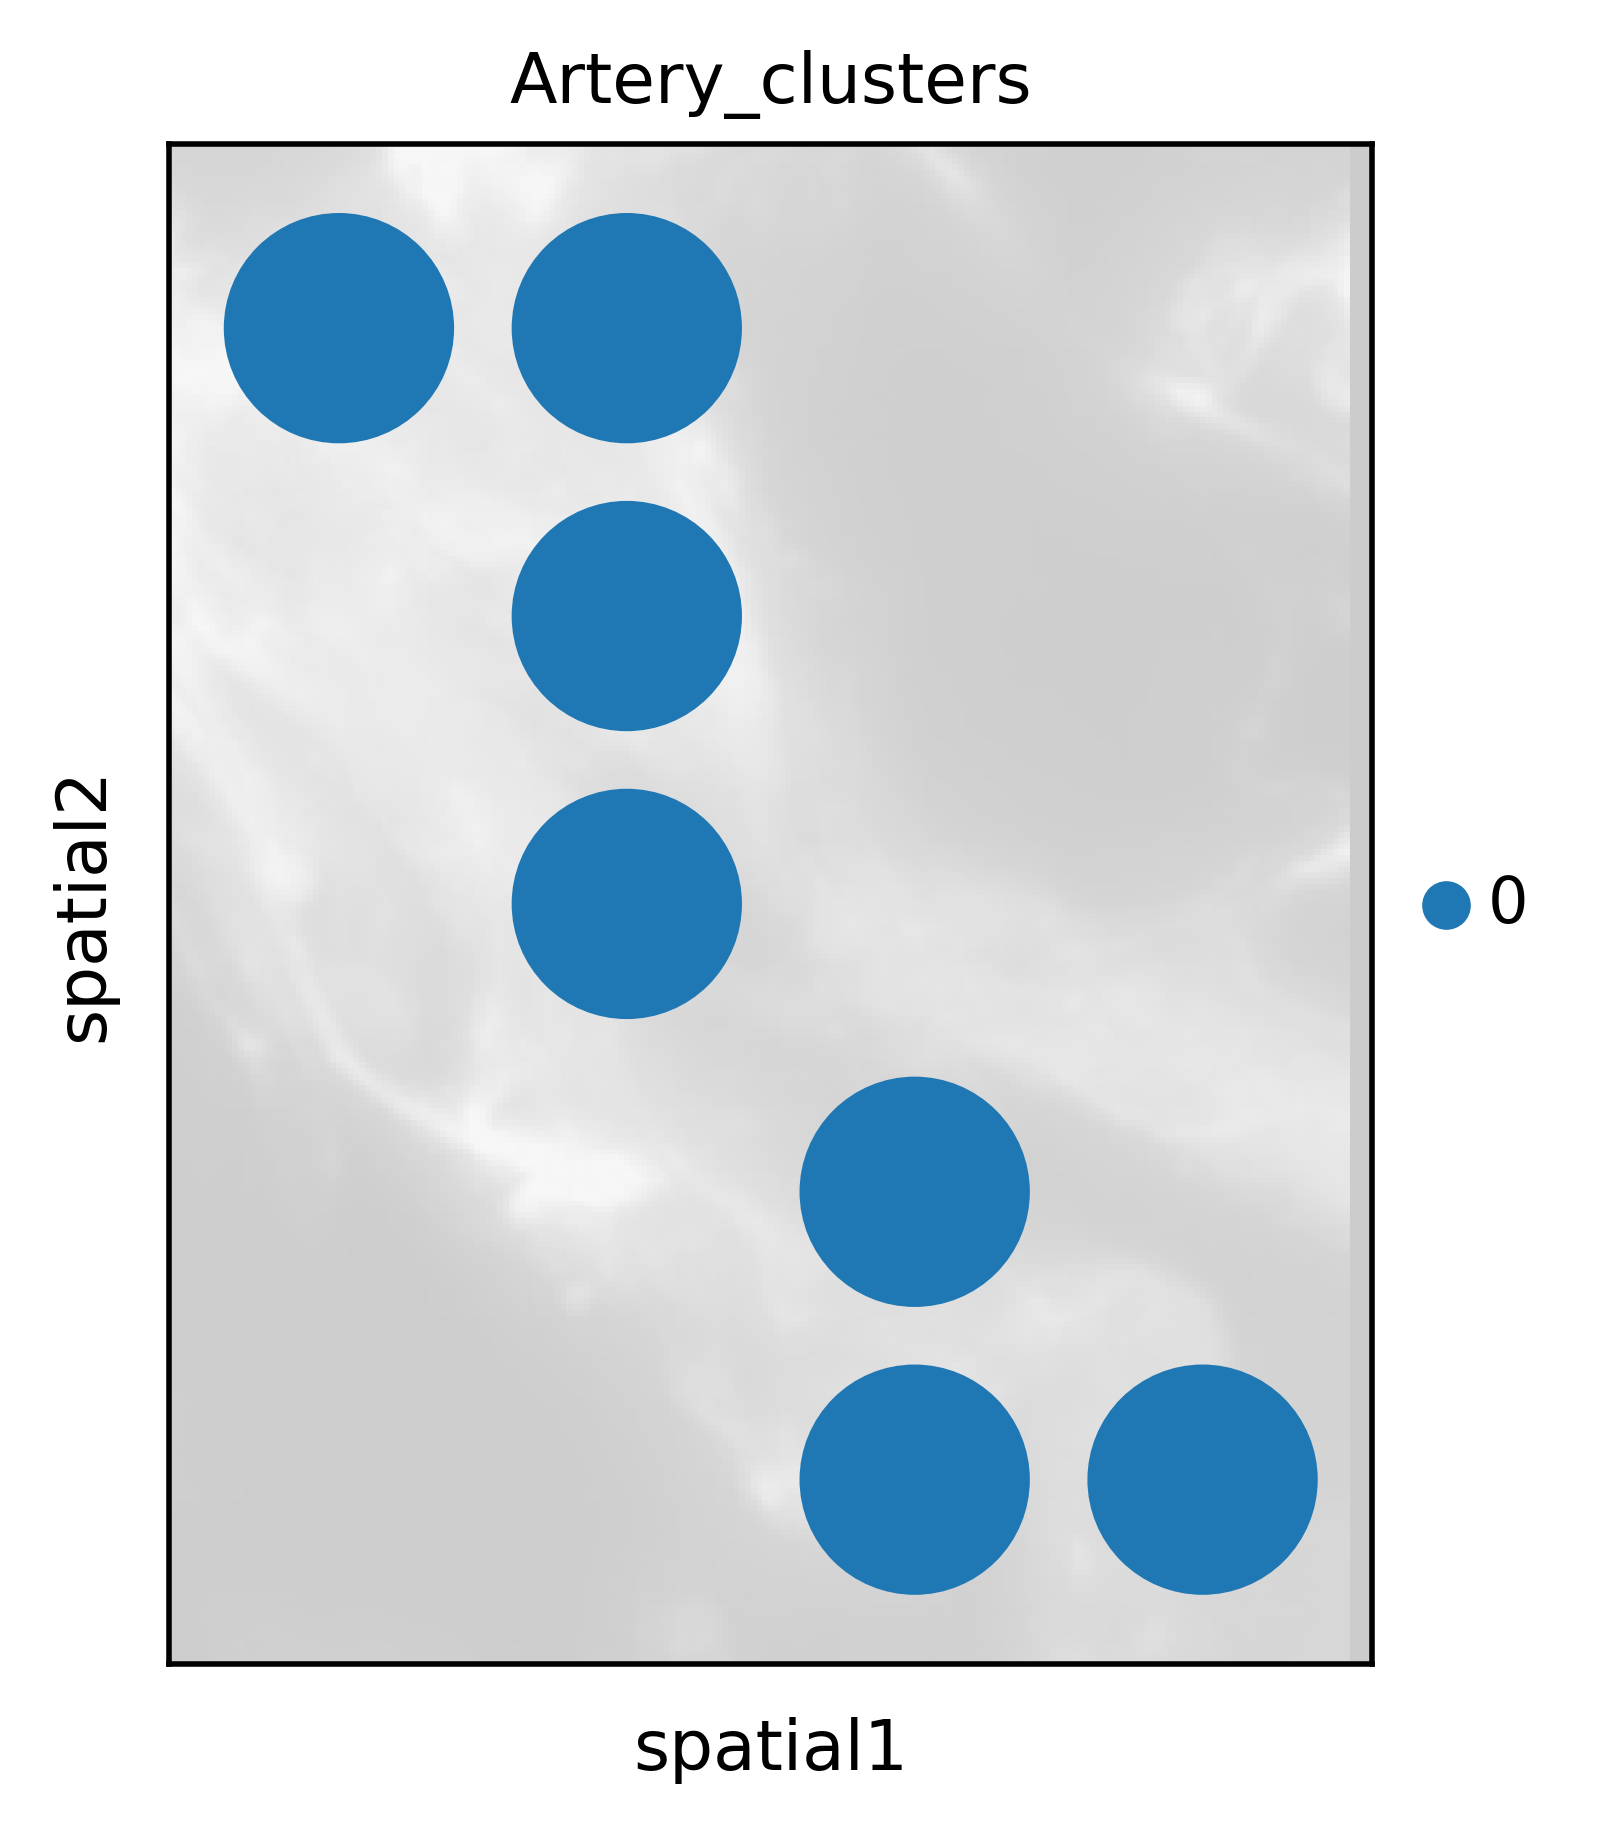

In [59]:
sc.pl.spatial(adata_aec_subset,color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

In [60]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/C2-3.csv")